In [2]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from cassandra.cluster import Cluster
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

import matplotlib.pyplot as plt

# Puedes ignorar desde aquí

## Datos del csv, los primeros que me envió Alejandro

In [3]:
df = pd.read_csv (r'/home/javi/Nextcloud/Universidad/Master/TFM/dataset/HK_TM.csv')
df[:8420]

,Received,Operating_Mode,Misison_Clock,BATT_TBAT1_TM,BATT_TBAT2_TM,BATT_TBAT3_TM,BATT_VBUS_TM,BATT_VBAT_TM,PSU_T_TM,P3V3_TM,...,MODEM_VBUS,RW_P5V,RW_VBUS,MTS_VBUS,BOOM1_VBUS,BOOM2_VBUS,TTC_STAT,SMA_SB01,SMA_SB02,Unnamed: 84
0,2020-09-03 23:01:18,SAFE,272036,1653,1645,1641,9,2364,1810,730,...,True,False,True,False,False,False,False,True,True,NaN
1,2020-09-03 23:02:18,SAFE,272281,1652,1647,1641,7,2363,1811,730,...,True,False,True,False,False,False,False,True,True,NaN
2,2020-09-03 23:03:58,SAFE,272525,1653,1646,1641,8,2361,1803,730,...,True,False,True,False,False,False,False,True,True,NaN
3,2020-09-03 23:04:40,SAFE,272770,1653,1646,1642,8,2361,1810,729,...,True,False,True,False,False,False,False,True,True,NaN
4,2020-09-03 23:05:18,SAFE,273015,1654,1646,1642,7,2359,1811,730,...,True,False,True,False,False,False,False,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8415,2021-05-24 23:28:39,SAFE,93166999,1656,1629,1643,8,2573,1771,731,...,True,False,True,False,False,False,False,True,True,NaN
8416,2021-05-25 10:55:19,SAFE,93335592,1654,1614,1637,8,2343,1763,731,...,True,False,True,False,False,False,False,True,True,NaN
8417,2021-05-25 11:00:19,SAFE,93336819,1640,1596,1623,8,2334,1766,730,...,True,False,True,False,False,False,False,True,True,NaN
8418,2021-05-28 13:23:49,SAFE,93358903,1664,1635,1649,7,2428,1774,730,...,True,False,True,False,False,False,False,True,True,NaN


## Datos de Cassandra, es necesario exportarlos a csv. Si hago una query directamente solo coge 5000 como máximo.

In [4]:
df_cassandra = pd.read_csv (r'/home/javi/Nextcloud/Universidad/Master/TFM/cassandra.csv')#, parse_dates=['sequencecount'], index_col='sequencecount')
df_cassandra = df_cassandra[::-1].reset_index()
df_cassandra.columns

Index(['index', 'tm_type', 'time_received', 'batt_t_ext_tm', 'batt_t_int_tm',
       'batt_tbat1_tm', 'batt_tbat2_tm', 'batt_tbat3_tm', 'batt_vbat_tm',
       'batt_vbus_tm', 'battery_status', 'boom1_vbus', 'boom2_vbus',
       'current_operating_mode', 'current_time', 'das_n15v', 'das_p15v',
       'das_p3v', 'das_p5v', 'ebox_t_ext_tm', 'ebox_t_int_tm', 'mgm1_p5v',
       'mgm1_t_tm', 'mgm1_x_tm', 'mgm1_y_tm', 'mgm1_z_tm', 'mgm2_p5v',
       'mgm2_t_tm', 'mgm2_x_tm', 'mgm2_y_tm', 'mgm2_z_tm', 'mgm3_n15v',
       'mgm3_p15v', 'mgm3_t_tm', 'mgm3_x_tm', 'mgm3_y_tm', 'mgm3_z_tm',
       'mgt_tx_tm', 'mgt_x_vbus', 'modem_t_tr_tm', 'modem_vbus',
       'mts_p1tts1_tm', 'mts_p1tts2_tm', 'mts_p1tts3_tm', 'mts_p1tts4_tm',
       'mts_p1tts5_tm', 'mts_p1tts6_tm', 'mts_vbus', 'n15v_tm', 'obc_t_tm',
       'p15v_tm', 'p3v3_tm', 'p5v_tm', 'pdu_ivbus_tm', 'pdu_p3v3', 'pdu_p5v',
       'psu_in15v_tm', 'psu_ip15v_tm', 'psu_ip3v3_tm', 'psu_ip5v_tm',
       'psu_t_tm', 'pv_ispxn_tm', 'pv_ispxp_tm', 'pv

## Los valores de las fechas de los datos en cassandra corresponden a la fecha de entrada en la bbdd, no a la de recepción en tierra

In [5]:
dates = []
for date in df['Received']:
    dates.append(pd.to_datetime(date, format="%Y/%m/%d %H:%M"))


df_cassandra.time_received=dates
df_cassandra

,index,tm_type,time_received,batt_t_ext_tm,batt_t_int_tm,batt_tbat1_tm,batt_tbat2_tm,batt_tbat3_tm,batt_vbat_tm,batt_vbus_tm,...,ss6_xn_tm,ss6_xp_tm,ss6_yn_tm,ss6_yp_tm,ss6_zn_tm,ss6_zp_tm,temp_a_p5v,temp_b_p5v,tm_id,ttc_stat
0,10270,Housekeeping,2020-09-03 23:01:18,1706,1705,1653,1645,1645,2364,9,...,5,5,4,5,5,5,True,True,24973552769025,False
1,10269,Housekeeping,2020-09-03 23:02:18,1704,1704,1652,1647,1647,2363,7,...,5,6,5,5,5,6,True,True,75476052804095,False
2,10268,Housekeeping,2020-09-03 23:03:58,1703,1702,1653,1646,1646,2361,8,...,5,5,5,5,6,5,True,True,6840289954733,False
3,10267,Housekeeping,2020-09-03 23:04:40,1702,1701,1653,1646,1646,2361,8,...,5,6,5,5,6,5,True,True,18991407762844,False
4,10266,Housekeeping,2020-09-03 23:05:18,1699,1700,1654,1646,1646,2359,7,...,5,6,5,5,5,6,True,True,11338525550988,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10266,4,Housekeeping,2021-11-24 22:12:07,1680,1687,1680,1652,1652,2356,8,...,5,5,5,5,5,5,True,True,53517918605202,False
10267,3,Housekeeping,2021-11-24 22:13:46,1680,1685,1676,1646,1646,2357,8,...,5,6,5,5,5,5,True,True,92791483895510,False
10268,2,Housekeeping,2021-11-24 23:49:27,1674,1679,1643,1621,1621,2485,8,...,5,5,5,5,5,6,True,True,83461232249310,False
10269,1,Housekeeping,2021-11-24 23:51:27,1672,1677,1645,1623,1623,2485,8,...,4,6,5,5,5,5,True,True,55988488951807,False


## Comprobacion de que los valores de la temperatura de las baterías son los mismos.

In [6]:
for i in range(0,500):
    csv = df['BATT_TBAT2_TM'][i]
    cassandra = df_cassandra['batt_tbat2_tm'][i]
    if csv != cassandra:
        print("Son diferentes")
        print("CSV: " + str(csv))
        print("Cassandra: " + str(cassandra))
        print(i)
        
        

## Código para importar los datos directamente de la BBDD

In [7]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)


In [8]:
cluster = Cluster()
session = cluster.connect('upmsat2db')
session.row_factory = pandas_factory

sql_query = "SELECT * FROM housekeeping;"

df_cassandra_biased = pd.DataFrame()


df_cassandra_biased = session.execute(sql_query, timeout=None)._current_rows
df_cassandra_biased.describe()

NoHostAvailable: ('Unable to connect to any servers', {'127.0.0.1:9042': ConnectionRefusedError(111, "Tried connecting to [('127.0.0.1', 9042)]. Last error: Connection refused")})

## Comprobando si hay valores vacíos en los datos de Cassandra

In [ ]:
columns = list(df_cassandra)
missing_values_str = "df_cassandra["
for column in columns:
    missing_values_str = missing_values_str + "(df_cassandra." + column + ".isna()) | "

missing_values_str = missing_values_str[:-3] + "]"   
eval(missing_values_str)

## Sustutuyendo outliers por la media de sus 4 vecinos

In [ ]:
def knn_mean(ts, n):
    out = np.copy(ts)
    sumat = 0
    for i, val in enumerate(ts):
        if val==4095: #if np.isnan(val):
            for j in range(i-int(n/2),i+int(n/2)+1):
                if j==i:
                    continue
                sumat += out[j]
            
            out[i]= sumat/(n)

            break
    return out

df_cassandra.batt_tbat1_tm =  knn_mean(df_cassandra.batt_tbat1_tm.values, 8)



# Hasta aquí

## Importando datos de CSV

In [9]:
df = pd.read_csv('/home/javi/Nextcloud/Universidad/Master/TFM/ST_analysis/upmsat.csv')

## Cambiando el formato de las fechas de 'str' a 'Timestamp'

In [10]:
dates_back = dates

In [11]:
df.time_received = np.array([pd.to_datetime(date, format="%Y/%m/%d %H:%M") for date in df.time_received])
df.columns

Index(['Unnamed: 0', 'index', 'tm_type', 'time_received', 'batt_t_ext_tm',
       'batt_t_int_tm', 'batt_tbat1_tm', 'batt_tbat2_tm', 'batt_tbat3_tm',
       'batt_vbat_tm', 'batt_vbus_tm', 'battery_status', 'boom1_vbus',
       'boom2_vbus', 'current_operating_mode', 'current_time', 'das_n15v',
       'das_p15v', 'das_p3v', 'das_p5v', 'ebox_t_ext_tm', 'ebox_t_int_tm',
       'mgm1_p5v', 'mgm1_t_tm', 'mgm1_x_tm', 'mgm1_y_tm', 'mgm1_z_tm',
       'mgm2_p5v', 'mgm2_t_tm', 'mgm2_x_tm', 'mgm2_y_tm', 'mgm2_z_tm',
       'mgm3_n15v', 'mgm3_p15v', 'mgm3_t_tm', 'mgm3_x_tm', 'mgm3_y_tm',
       'mgm3_z_tm', 'mgt_tx_tm', 'mgt_x_vbus', 'modem_t_tr_tm', 'modem_vbus',
       'mts_p1tts1_tm', 'mts_p1tts2_tm', 'mts_p1tts3_tm', 'mts_p1tts4_tm',
       'mts_p1tts5_tm', 'mts_p1tts6_tm', 'mts_vbus', 'n15v_tm', 'obc_t_tm',
       'p15v_tm', 'p3v3_tm', 'p5v_tm', 'pdu_ivbus_tm', 'pdu_p3v3', 'pdu_p5v',
       'psu_in15v_tm', 'psu_ip15v_tm', 'psu_ip3v3_tm', 'psu_ip5v_tm',
       'psu_t_tm', 'pv_ispxn_tm', 'pv_

In [12]:
type(df.time_received[0])

pandas._libs.tslibs.timestamps.Timestamp

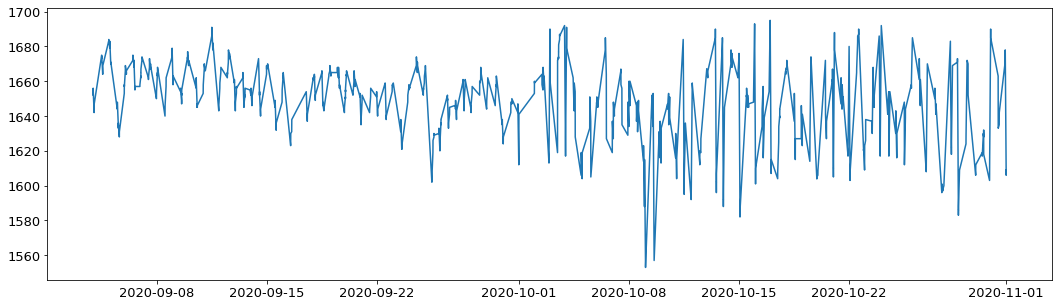

In [13]:
chunk = 8418
chunk = len(df)
chunk = 1124 # Primer mes
chunk = 2414 # Dos primeros meses

x = df.time_received[:chunk]
y = df.batt_tbat1_tm[:chunk]


plt.rc("figure", figsize=(18, 5))
plt.rc("font", size=13)
plt.plot(x, y)

array([ -0.4819544 ,  -0.38495692,   0.48143978, ...,  -5.81723984,
       -17.48366776, -17.5123009 ])

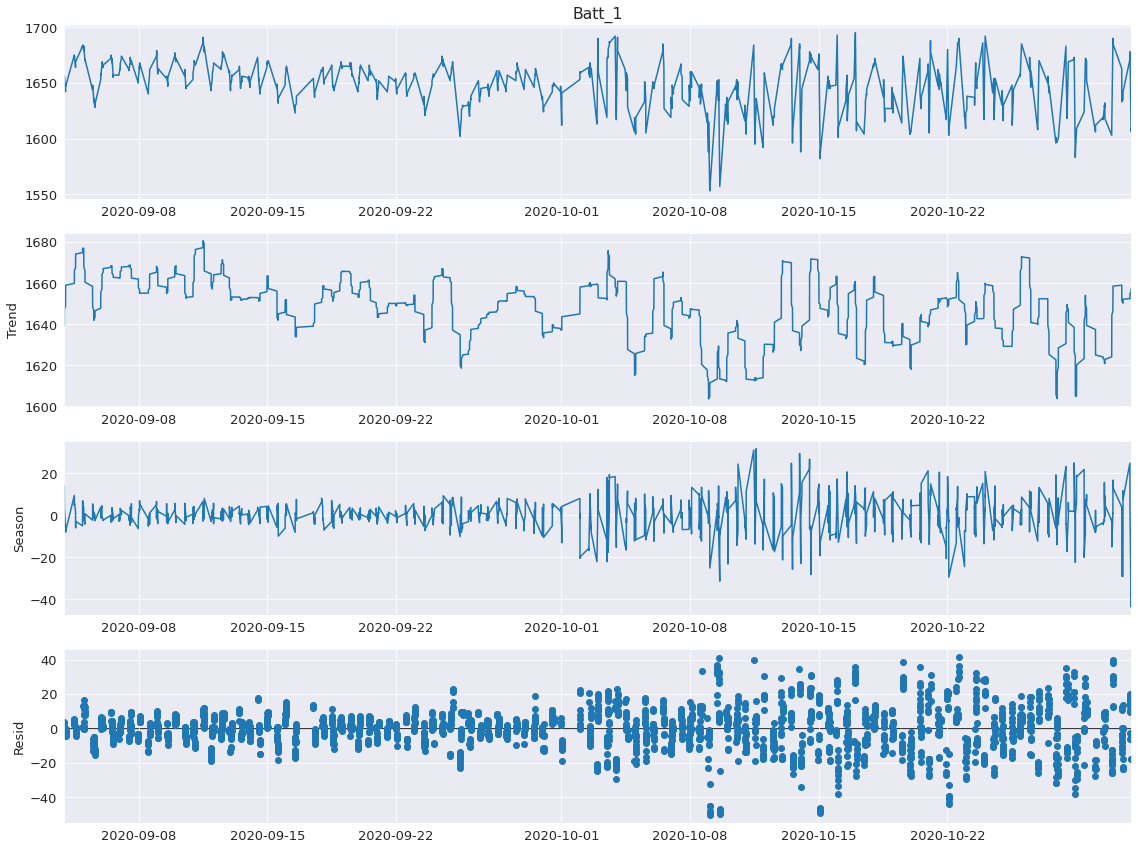

In [14]:

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

raw_data = df['batt_tbat1_tm'][:chunk]
dates = dates[:chunk]
data = pd.Series(
    raw_data.values, index=dates, name="Batt_1"
)
stl = STL(data,  period=20)
res = stl.fit()
fig = res.plot()
res.resid.values

## Calculo de las medias y varianzas en diferentes divisiones de los datos para comprobar su estabilidad

In [15]:
values = df.batt_tbat1_tm.values[:chunk]
values = res.resid.values
# getting the count to split the dataset into 3
parts = int(len(values)/5)
 
# splitting the data into three parts
part_1, part_2, part_3, part_4, part_5 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)], values[(parts*3):(parts*4)], values[(parts*4):(parts*5)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3, mean_4, mean_5 = part_1.mean(), part_2.mean(), part_3.mean(), part_4.mean(), part_5.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3, var_4, var_5 = part_1.var(), part_2.var(), part_3.var(), part_4.var(), part_5.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f , mean4=%f , mean5=%f' % (mean_1, mean_2, mean_3, mean_4, mean_5))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f, variance4=%f, variance5=%f' % (var_1, var_2, var_3, var_4, var_5))

mean1=0.175939, mean2=-0.119571, mean3=-0.184842 , mean4=0.184272 , mean5=0.074986
variance1=35.487870, variance2=45.213260, variance3=97.006441, variance4=276.750462, variance5=277.339735


## Aplicando log al array de valores para suavizar la varianza

In [16]:
values = df.batt_tbat1_tm.values[:chunk]
values_log = np.array([math.log(value) for value in values])
# getting the count to split the dataset into 3
parts = int(len(values)/5)
 
# splitting the data into three parts
part_1, part_2, part_3, part_4, part_5 = values_log[0:parts], values_log[parts:(
    parts*2)], values_log[(parts*2):(parts*3)], values_log[(parts*3):(parts*4)], values_log[(parts*4):(parts*5)]
 
# calculating the mean of the separated three
# parts of data individually.
mean_1, mean_2, mean_3, mean_4, mean_5 = part_1.mean(), part_2.mean(), part_3.mean(), part_4.mean(), part_5.mean()
 
# calculating the variance of the separated
# three parts of data individually.
var_1, var_2, var_3, var_4, var_5 = part_1.var(), part_2.var(), part_3.var(), part_4.var(), part_5.var()
 
# printing the mean of three groups
print('mean1=%f, mean2=%f, mean3=%f , mean4=%f , mean5=%f' % (mean_1, mean_2, mean_3, mean_4, mean_5))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance3=%f, variance4=%f, variance5=%f' % (var_1, var_2, var_3, var_4, var_5))

mean1=7.415223, mean2=7.407458, mean3=7.406256 , mean4=7.401551 , mean5=7.403615
variance1=0.000053, variance2=0.000082, variance3=0.000162, variance4=0.000326, variance5=0.000283


## Comprobando la estacionalidad con el método adfuller

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
res = adfuller(df.batt_tbat1_tm)
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
    
# KPSS Test
result = kpss(values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Augmneted Dickey_fuller Statistic: -6.315496
p-value: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567

KPSS Statistic: 2.111059
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/javi/anaconda3/envs/TFM/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Random Walk

In [18]:
random_walk = []
for i in range(1, len(df)):
    actual_value = df.batt_tbat1_tm[i-1]
    previous_value = df.batt_tbat1_tm[i]
    random_walk.append(actual_value-previous_value)
np.array(random_walk).mean()

0.0006815968841285297

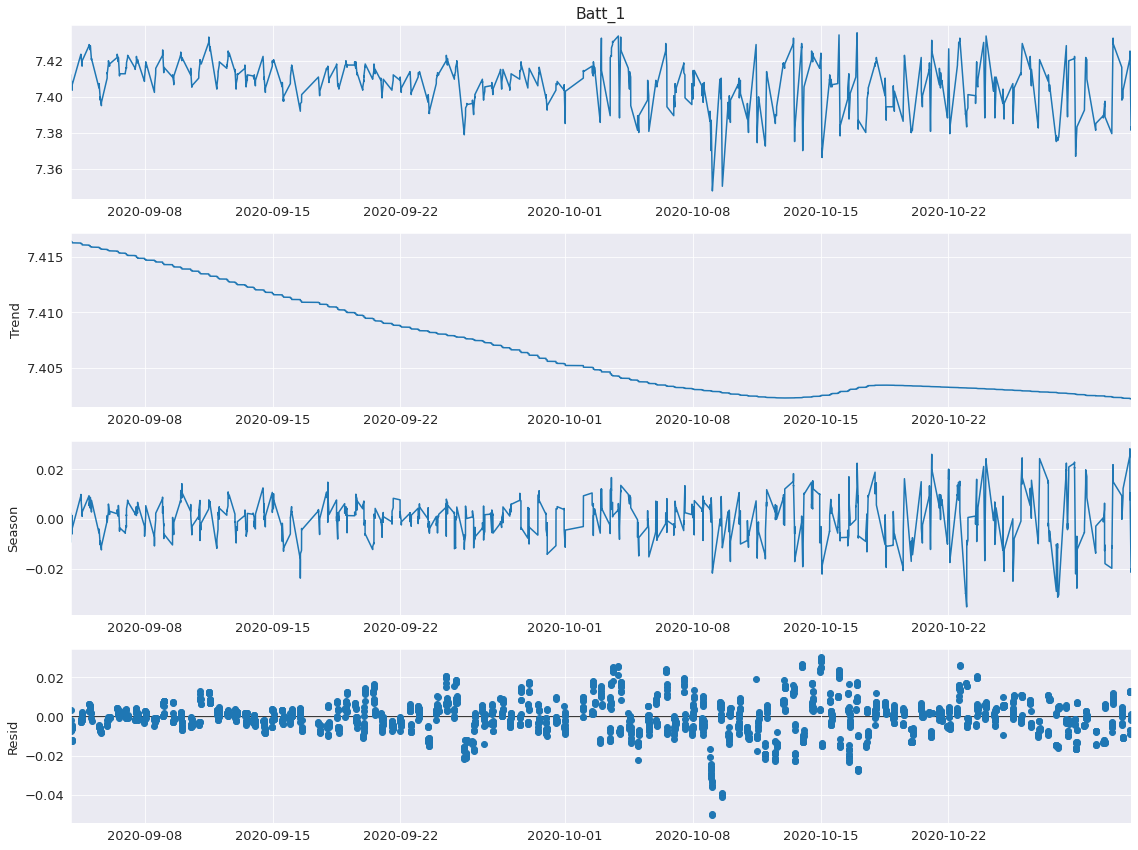

In [19]:

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

#raw_data = random_walk[:longitude]
raw_data = [math.log(value) for value in df.batt_tbat1_tm.values][:chunk]
dates = dates[:chunk]
data = pd.Series(
    raw_data, index=dates, name="Batt_1"
)
stl = STL(data, period=600)
res = stl.fit()
fig = res.plot()

In [20]:
import pmdarima.arima as arima

arima.ndiffs(df.batt_tbat1_tm.values[:chunk])
# El resultado es 1, hace falta un nivel de diferenciacion

1

In [21]:
# ¿Valor de m (número de periodos)?
arima.nsdiffs(df.batt_tbat1_tm.values[:chunk],50)

0

## Autocorrelation Function (ACF) plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

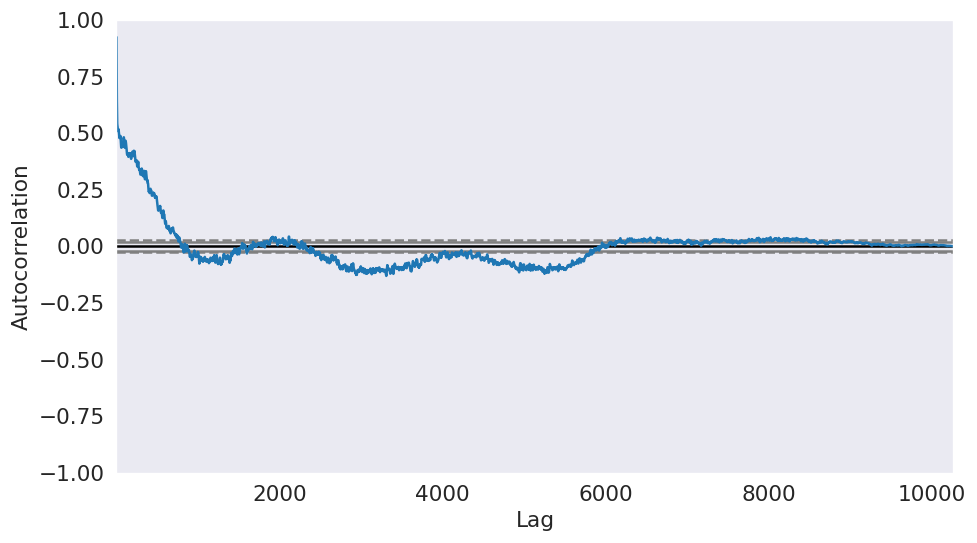

In [22]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.batt_tbat1_tm.tolist())

## Shoothen the TS

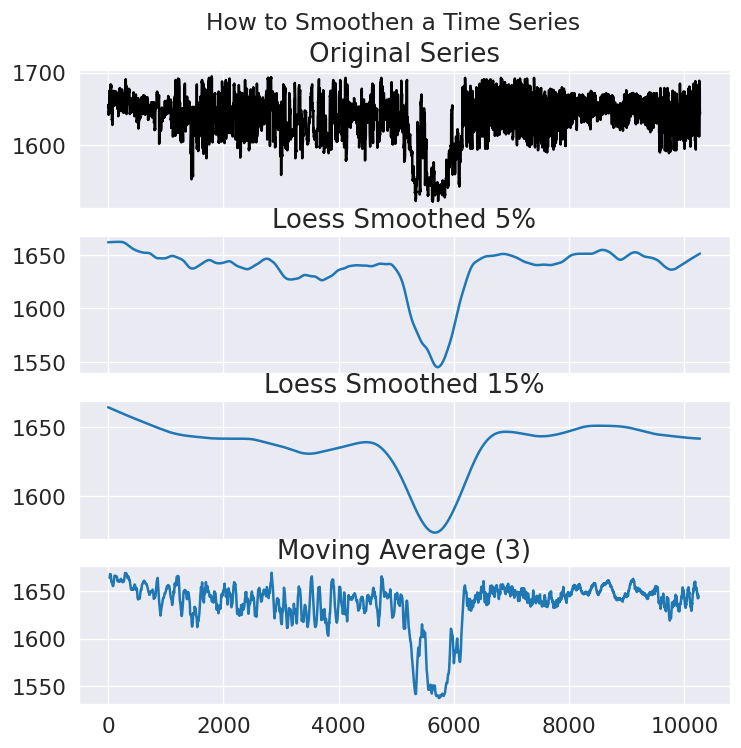

In [23]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})


# 1. Moving Average
df_ma = df.batt_tbat1_tm.rolling(50, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.batt_tbat1_tm, np.arange(len(df.batt_tbat1_tm)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.batt_tbat1_tm, np.arange(len(df.batt_tbat1_tm)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df.batt_tbat1_tm.plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests
print(type(df.batt_tbat1_tm))
grangercausalitytests(df[['batt_tbat1_tm', 'batt_tbat3_tm']], maxlag=3)

<class 'pandas.core.series.Series'>

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.3925 , p=0.0004  , df_denom=10267, df_num=1
ssr based chi2 test:   chi2=12.3961 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3886 , p=0.0004  , df=1
parameter F test:         F=12.3925 , p=0.0004  , df_denom=10267, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.7351  , p=0.0002  , df_denom=10264, df_num=2
ssr based chi2 test:   chi2=17.4788 , p=0.0002  , df=2
likelihood ratio test: chi2=17.4639 , p=0.0002  , df=2
parameter F test:         F=8.7351  , p=0.0002  , df_denom=10264, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6008  , p=0.0000  , df_denom=10261, df_num=3
ssr based chi2 test:   chi2=22.8179 , p=0.0000  , df=3
likelihood ratio test: chi2=22.7926 , p=0.0000  , df=3
parameter F test:         F=7.6008  , p=0.0000  , df_denom=10261, df_num=3


{1: ({'ssr_ftest': (12.392466778465757, 0.00043293787813691214, 10267.0, 1),
   'ssr_chi2test': (12.396087836256289, 0.00043023427806926107, 1),
   'lrtest': (12.388612692360766, 0.00043196006991520774, 1),
   'params_ftest': (12.39246677859221, 0.0004329378781073463, 10267.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.735141057071088, 0.00016203220100116279, 10264.0, 2),
   'ssr_chi2test': (17.47879257892888, 0.00016015054330093507, 2),
   'lrtest': (17.463934171930305, 0.00016134476484234254, 2),
   'params_ftest': (8.735141057075378, 0.0001620322010004314, 10264.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.600793442676434, 4.491827397015326e-05, 10261.0, 3),
   'ssr_chi2test': (22.817935991443804, 4.40698591375386e-05, 3),
   'lrtest': (22.79262005185592, 4.460840319741091e-05, 3),
   'params_ftest': (7.600793442676665, 4.4918273970132035e-05, 10261.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0

2022-02-24 11:02:09.562812: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-24 11:02:09.584185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 11:02:09.595711: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


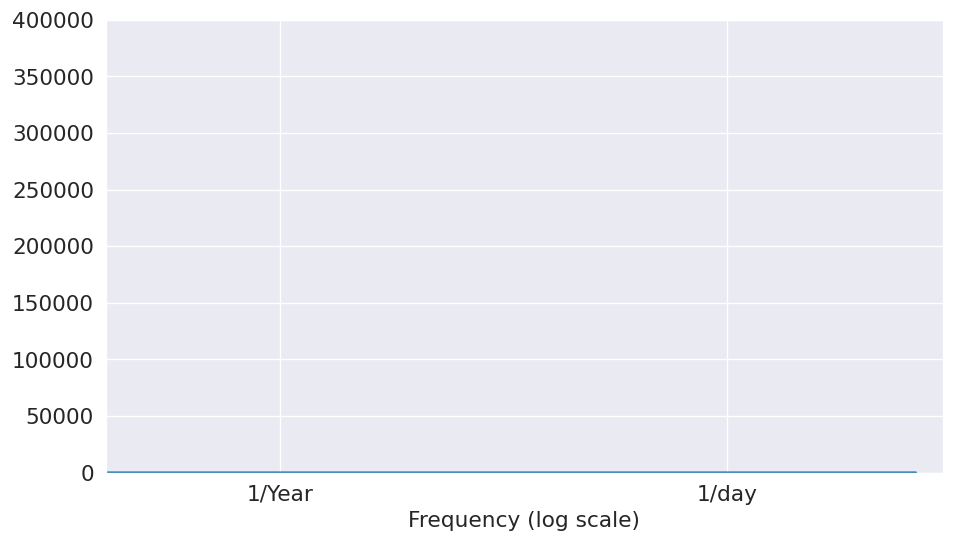

In [25]:
values = res.resid.values


fft = tf.signal.rfft(values)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(values)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

1.0


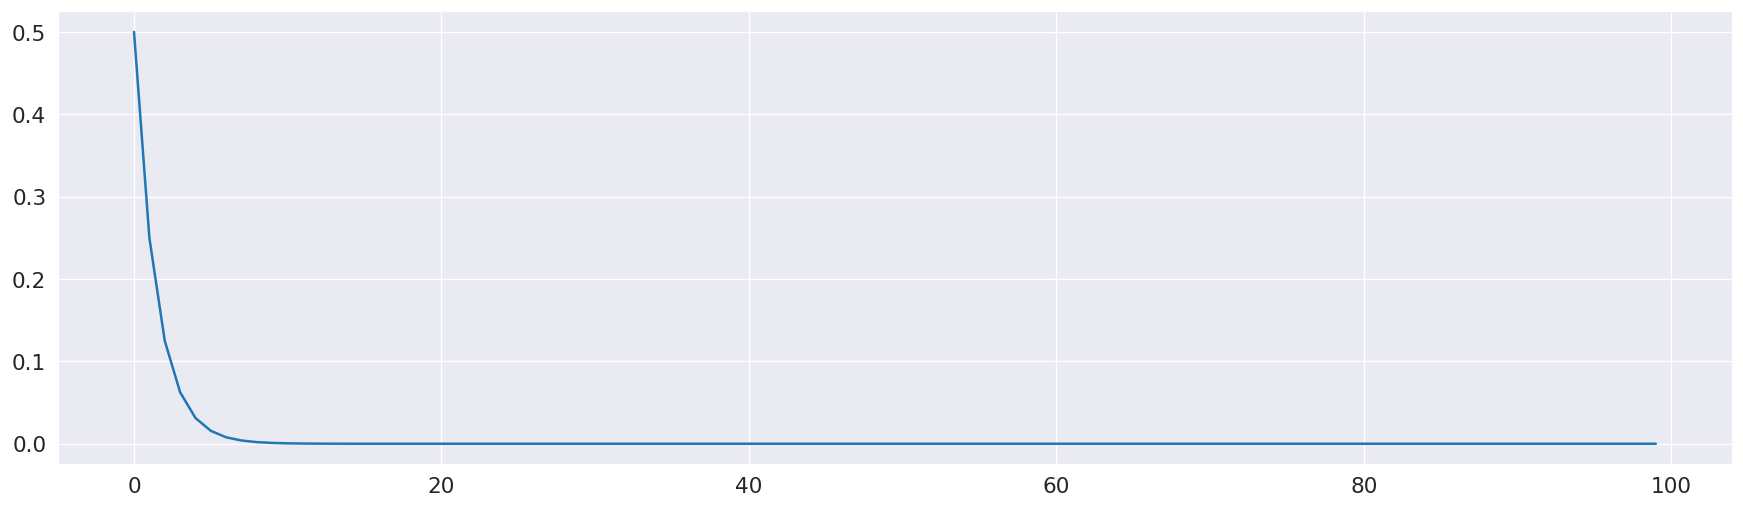

In [26]:
import math
import matplotlib.pyplot as plt

alpha = 0.5
values = []
indexes = []

for n in range(0,100):
    value = alpha*math.pow((1-alpha),n)
    values.append(value)
    indexes.append(n)

plt.rc("figure", figsize=(18, 5))
plt.rc("font", size=13)
plt.plot(indexes, values)
print(sum(values))